In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
pic_path = '../local/pictures/'

In [16]:
source = 'mgdb_3.0'	# "mgdb_3.0" or "ensembl"
file_path = f'./nw.hsa_{source}_premirna.WGD_flag.intragenic_flag.7mer.s5.tsv'

df = pd.read_csv(file_path, sep='\t', header=None)
df

,0,1,2,3,4
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
...,...,...,...,...,...
2462,Hsa-Let-7-P1b,Hsa-Let-7-P2b2,44.0,SSD,NaN
2463,Hsa-Let-7-P1b,Hsa-Let-7-P2b1,46.0,SSD,NaN
2464,Hsa-Let-7-P1b,Hsa-Let-7-P2a3,46.0,SSD,NaN
2465,Hsa-Let-7-P1b,Hsa-Let-7-P2a2,48.0,SSD,NaN


In [17]:
# count pairs where the 4th column is "WGD_intragenic"
wgd_intragenic_count = df[df[4] == 'WGD_intragenic'].shape[0]
print(f'Number of intragenic WGD pairs: {wgd_intragenic_count}')
wgd_count = df[df[3] == 'WGD'].shape[0]
print(f'Number of general WGD pairs: {wgd_count}')

Number of intragenic WGD pairs: 12
Number of general WGD pairs: 102


In [18]:
df[df[4] == 'WGD_intragenic']

,0,1,2,3,4
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
5,Hsa-Mir-204-P1,Hsa-Mir-204-P2,46.0,WGD,WGD_intragenic
6,Hsa-Mir-153-P1,Hsa-Mir-153-P2,50.0,WGD,WGD_intragenic
7,Hsa-Mir-148-P3,Hsa-Mir-148-P4,40.0,WGD,WGD_intragenic
8,Hsa-Mir-128-P1,Hsa-Mir-128-P2,49.0,WGD,WGD_intragenic
9,Hsa-Mir-103-P2,Hsa-Mir-103-P4,51.0,WGD,WGD_intragenic


In [19]:
pairs_to_relabel = [
	['Hsa-Mir-199-P1-v1', 'Hsa-Mir-199-P2-v1'],
	['Hsa-Mir-199-P1-v1', 'Hsa-Mir-199-P3-v1'],
	['Hsa-Mir-199-P2-v1', 'Hsa-Mir-199-P3-v1'],
	['Hsa-Mir-196-P3', 'Hsa-Mir-196-P4'], # AKA MIR196-A1 MIR196-A2
	['Hsa-Mir-10-P1c-v1', 'Hsa-Mir-10-P1b-v1'], # AKA MIR10-A MIR10-B
]

for pair in pairs_to_relabel:
	condition = ((df[0] == pair[0]) & (df[1] == pair[1]) | (df[0] == pair[1]) & (df[1] == pair[0]))
	df.loc[condition & (df[3] == 'WGD'), 4] = 'WGD_intragenic'
	
	df.loc[condition & (df[3] == 'SSD'), 4] = 'WGD_intragenic'
	df.loc[condition & (df[3] == 'SSD'), 3] = 'WGD'

df[df[4] == 'WGD_intragenic']

,0,1,2,3,4
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
5,Hsa-Mir-204-P1,Hsa-Mir-204-P2,46.0,WGD,WGD_intragenic
6,Hsa-Mir-153-P1,Hsa-Mir-153-P2,50.0,WGD,WGD_intragenic
7,Hsa-Mir-148-P3,Hsa-Mir-148-P4,40.0,WGD,WGD_intragenic
8,Hsa-Mir-128-P1,Hsa-Mir-128-P2,49.0,WGD,WGD_intragenic
9,Hsa-Mir-103-P2,Hsa-Mir-103-P4,51.0,WGD,WGD_intragenic


In [20]:
df[df[4] == 'WGD_intragenic'].shape

(17, 5)

In [21]:
df_wgd = df[df[3] == 'WGD']
df_wgd_intragenic = df_wgd[df_wgd[4] == 'WGD_intragenic']
df_ssd = df[df[3] == 'SSD']

In [22]:
df_ssd.head(50)

,0,1,2,3,4
102,Hsa-Mir-96-P2,Hsa-Mir-96-P3-v1,19.0,SSD,NaN
103,Hsa-Mir-96-P1,Hsa-Mir-96-P3-v1,23.0,SSD,NaN
104,Hsa-Mir-96-P1,Hsa-Mir-96-P2,20.0,SSD,NaN
105,Hsa-Mir-92-P1d,Hsa-Mir-92-P2d,38.0,SSD,NaN
106,Hsa-Mir-92-P1d,Hsa-Mir-92-P2c,26.0,SSD,NaN
107,Hsa-Mir-92-P1d,Hsa-Mir-92-P2a,26.0,SSD,NaN
108,Hsa-Mir-92-P1c,Hsa-Mir-92-P2d,42.0,SSD,NaN
109,Hsa-Mir-92-P1c,Hsa-Mir-92-P2c,26.0,SSD,NaN
110,Hsa-Mir-92-P1c,Hsa-Mir-92-P2a,30.0,SSD,NaN
111,Hsa-Mir-92-P1a,Hsa-Mir-92-P2d,42.0,SSD,NaN


In [23]:
df_wgd_scores = df_wgd[2].astype(int)
df_ssd_scores = df_ssd[2].astype(int)
df_wgd_intragenic_scores = df_wgd_intragenic[2].astype(int)

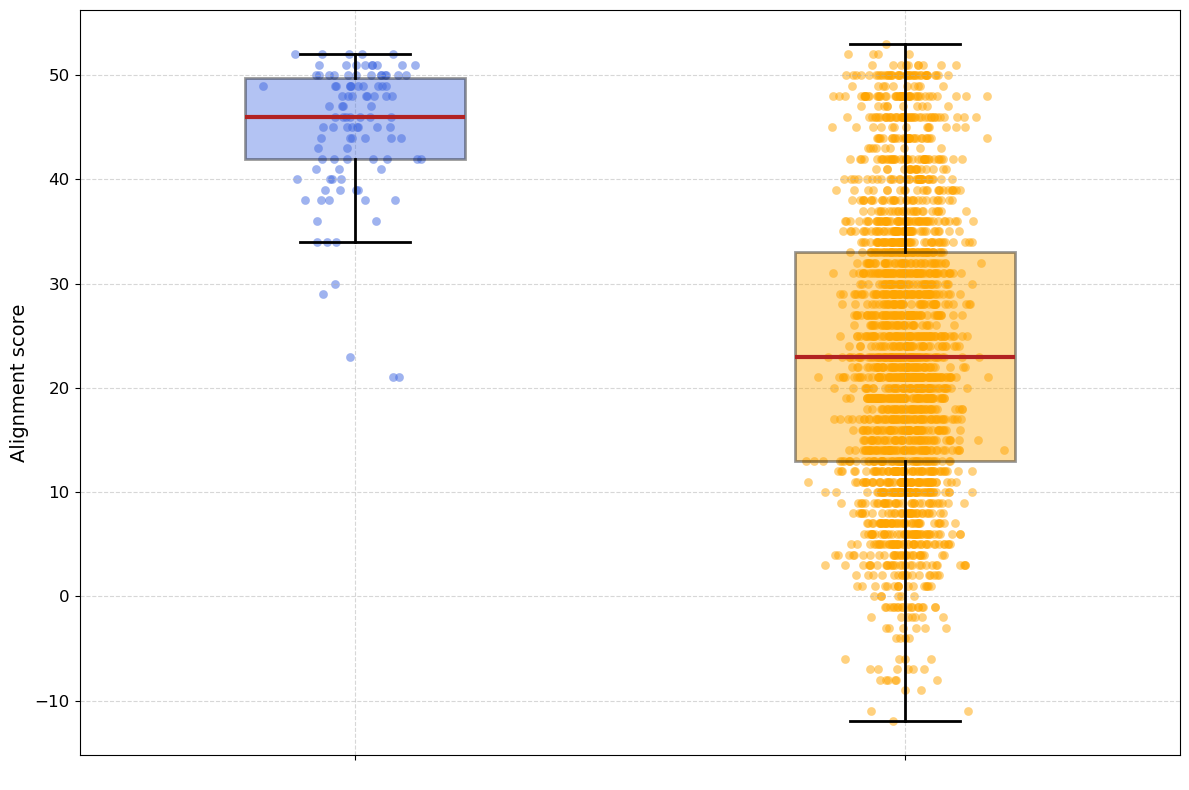

In [24]:
data = [df_wgd_scores, df_ssd_scores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}true_duplicates_mirgenedbSSD_sequence_similarity_boxplot.png', dpi=300)
plt.show()

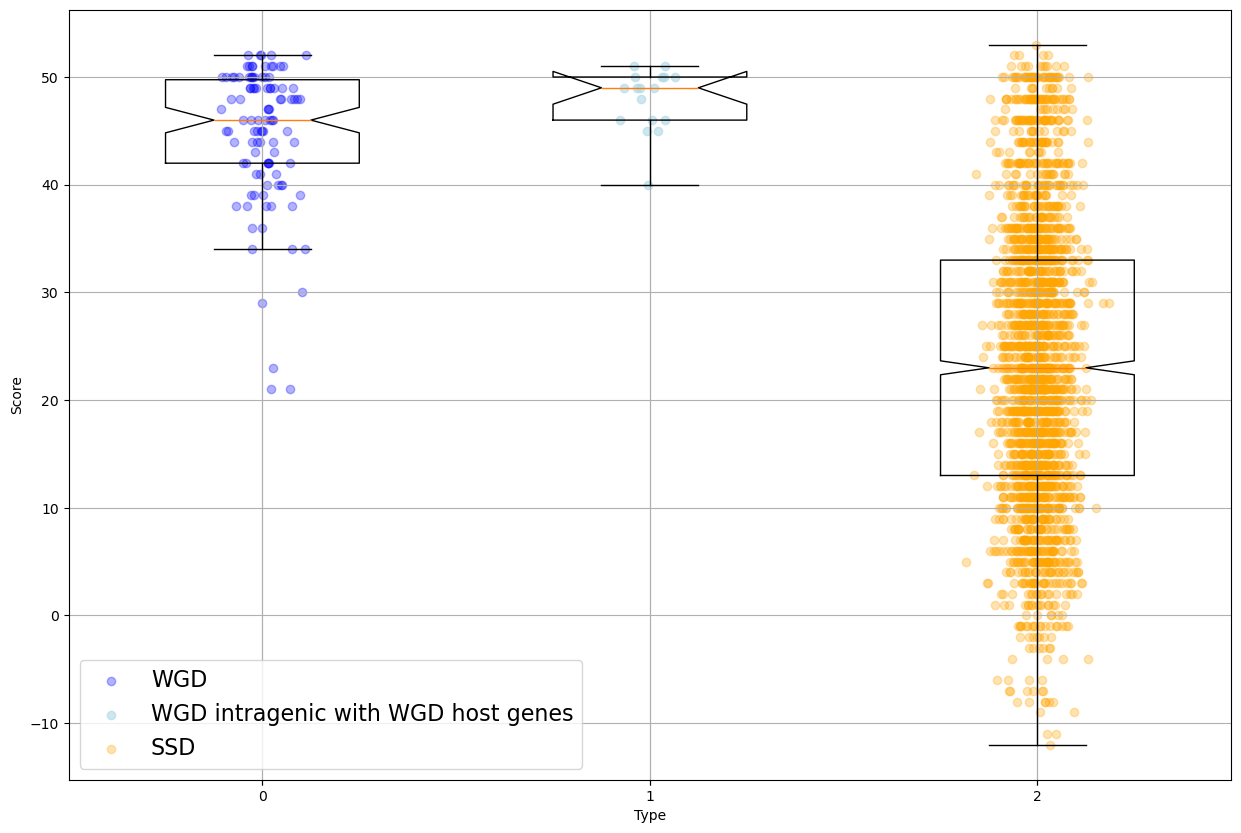

In [25]:
plt.figure(figsize=(15, 10))
plt.xlabel('Type')
plt.ylabel('Score')
plt.xticks([0, 1, 2], ['WGD', 'WGD intragenic with WGD host genes', 'SSD'])
plt.boxplot([df_wgd_scores, df_wgd_intragenic_scores, df_ssd_scores], positions=[0, 1, 2], widths=0.5, notch=True, showfliers=False)
plt.scatter(np.random.normal(0, 0.05, size=len(df_wgd_scores)), df_wgd_scores, alpha=0.3, color='blue', label='WGD')
plt.scatter(np.random.normal(1, 0.05, size=len(df_wgd_intragenic_scores)), df_wgd_intragenic_scores, alpha=0.6, color='lightblue', label='WGD intragenic with WGD host genes')
plt.scatter(np.random.normal(2, 0.05, size=len(df_ssd_scores)), df_ssd_scores, alpha=0.3, color='orange', label='SSD')
plt.legend(fontsize=16, loc='lower left')
plt.grid()
plt.show()

In [26]:
print(f'Number of WGD pairs: {len(df_wgd_scores)}')
print(f'Number of WGD intragenic pairs: {len(df_wgd_intragenic_scores)}')
print(f'Number of SSD pairs: {len(df_ssd_scores)}')

Number of WGD pairs: 106
Number of WGD intragenic pairs: 17
Number of SSD pairs: 2361
